# Single asperity simulations (3D)

In this tutorial, we simulate slip on a 2D fault (within a 3D medium) with a single velocity-weakening asperity, embedded in a velocity-strengthening (creeping) matrix. We begin by importing some modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Make plots interactive in the notebook
# %matplotlib widget

# import matplotlib.pyplot as plt
# import numpy as np

# import os
# import sys

# # Import QDYN wrapper
# from qdyn.pyqdyn import qdyn





%matplotlib inline

import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt

# Add QDYN source directory to PATH
# Go up in the directory tree
# qdyn_dir = "/home/crodriguezpiceda/qdyn_intel_openmp/qdyn"
qdyn_dir = "/work/e820/e820/cpiceda/qdyn_github/qdyn"


# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn")
)

# Append src directory to Python path
sys.path.append(src_dir)
# Get QDYN post_processing library directory
post_processing_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn", "utils", "post_processing")
)
# Append post_processing library directory to Python path
sys.path.append(post_processing_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year

# Instantiate the QDYN class object
# p = qdyn()




To prepare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps: 

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation

In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b) < 0$, and such that the matrix has $(a - b) > 0$.

In [3]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year
L = 5e3                     # Length of fault along-strike
W = 5e3                     # Length of fault along-dip
resolution = 5              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 2        # Simulation dimensionality (2D fault in 3D medium)
set_dict["FAULT_TYPE"] = 2     # Thrust fault
set_dict["TMAX"] = 5*t_yr      # Maximum simulation time [s]
set_dict["NTOUT_OT"] = 10      # Save output every N steps
set_dict["NTOUT_OX"] = 100     # Save output every N steps
set_dict["NXOUT_OX"] = 2       # Snapshot resolution along-strike (every N elements)
set_dict["NWOUT_OX"] = 2       # Snapshot resolution along-dip (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 1e7        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)
set_dict["Z_CORNER"] = -1e4    # Base of the fault (depth taken <0); NOTE: Z_CORNER must be < -W !
set_dict["DIP_W"] = 30         # Dip of the fault

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.2e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 1e-3     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]

# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((set_dict["SET_DICT_RSF"]["B"] - set_dict["SET_DICT_RSF"]["A"]) * set_dict["SIGMA"])

print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")

# Find next power of two for number of mesh elements
Nx = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
Nw = int(np.power(2, np.ceil(np.log2(resolution * W / Lb))))

dx = L / Nx
dw = W / Nw

# Spatial coordinate for mesh
x = np.linspace(-(L - dx) / 2, (L - dx) / 2, Nx, dtype=float)
z = np.linspace(-(W - dw) / 2, (W - dw) / 2, Nw, dtype=float)
X, Z = np.meshgrid(x, z)
z = -(set_dict["Z_CORNER"] + (z + W/2) * np.cos(set_dict["DIP_W"] * np.pi / 180.))

# Set mesh size and fault length
set_dict["NX"] = Nx
set_dict["NW"] = Nw
set_dict["L"] = L
set_dict["W"] = W 
set_dict["DW"] = W / Nw
# Set time series output node to the middle of the fault
set_dict["IC"] = Nx * (Nw // 2) + Nx // 2

# The number of nodes for parallel execution
# Set to 1 for serial execution
set_dict["NPROC"] = 8

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
scale = 1e3
p.mesh_dict["A"] = 2 * set_dict["SET_DICT_RSF"]["B"] * (1 - 0.9*np.exp(- (X**2 + Z**2) / (2 * scale**2))).ravel()

p.set_dict["VERBOSE"] = 0
p.set_dict["DEBUG"] = 0

# Write input to qdyn.in
p.write_input()

Process zone size: 300.0 m 	 Nucleation length: 375.0 m


True

To see the effect of setting a heterogeneous value of a over the mesh, we can plot $(a-b)$ versus position on the fault:

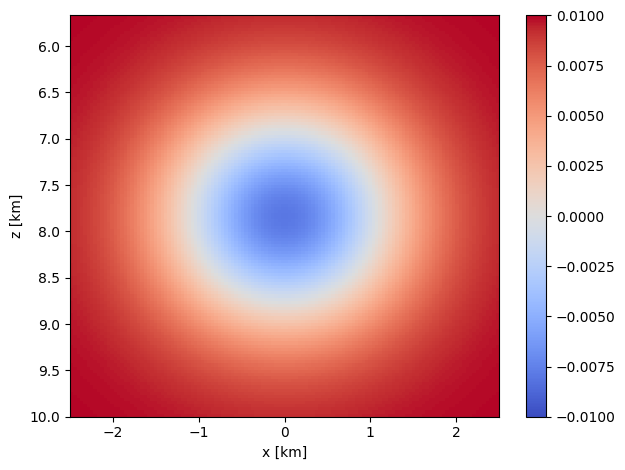

In [4]:
plt.figure()
plt.pcolormesh(x * 1e-3, z * 1e-3, (p.mesh_dict["A"] - p.mesh_dict["B"]).reshape(X.shape), 
               vmin=-0.01, vmax=0.01, cmap="coolwarm")
plt.colorbar()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b) < 0$, embedded in a stable matrix with $(a-b) > 0$.

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that if `set_dict["VERBOSE"]` is set to `0` (default), then the screen output logged to a file, so you won't see any output here.

In [ ]:
# p.run()

The simulation output can be reloaded without re-running the simulation, so you only have to call `p.run()` again if you made any changes to the input parameters. To read/process the output, call:

In [6]:
p.read_output(read_ot=True, read_ox=True, read_fault=True)

True

Instead of using an auxiliary library of plotting functions (`plot_functions.py`), we can directly access the time series output from `p.ot` to plot the slip rate and shear stress in the middle of the fault:

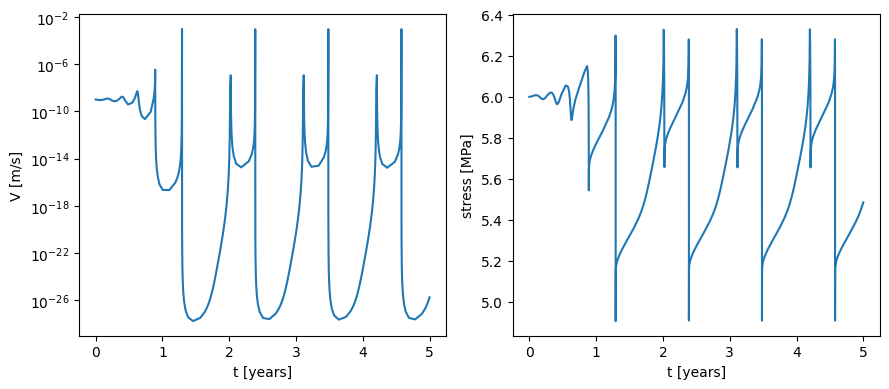

In [7]:
# Time-series plot at the middle of the fault
plt.figure(figsize=(9, 4))

# Slip rate
plt.subplot(121)
plt.plot(p.ot[0]["t"] / t_yr, p.ot[0]["v"])
plt.xlabel("t [years]")
plt.ylabel("V [m/s]")
plt.yscale("log")

# Shear stress
plt.subplot(122)
plt.plot(p.ot[0]["t"] / t_yr, p.ot[0]["tau"] * 1e-6)
plt.xlabel("t [years]")
plt.ylabel("stress [MPa]")

plt.tight_layout()
plt.show()

Similarly, we can access individual snapshots from `p.ox`:

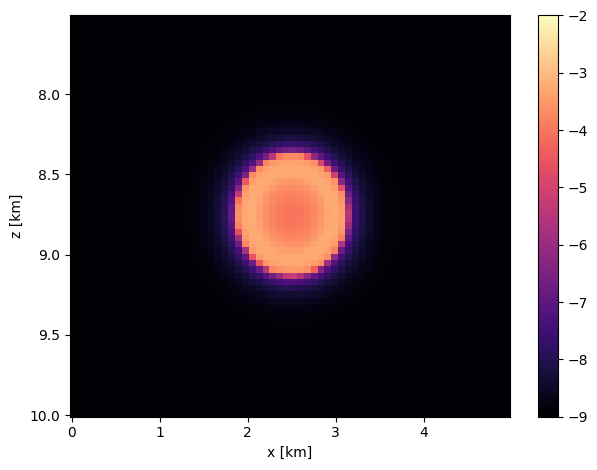

In [8]:
# Get the x, z coordinates of the fault
x_ox = p.ox["x"].unique()
z_ox = p.ox["z"].unique()

X, Z = np.meshgrid(x_ox, z_ox)

# Number of snapshots
Nt = len(p.ox["v"]) // (len(x_ox) * len(z_ox))

# Get velocity snapshots
V_ox = p.ox["v"].values.reshape((Nt, len(z_ox), len(x_ox)))

# Plot one snapshot of slip rate
plt.figure()

plt.pcolormesh(x_ox * 1e-3, -z_ox * 1e-3, np.log10(V_ox[14]), cmap="magma", vmin=-9, vmax=-2)
plt.xlabel("x [km]")
plt.ylabel("z [km]")

plt.gca().invert_yaxis()
plt.colorbar()

plt.tight_layout()
plt.show()

## Compute seismic events from simulation
This section shows the workflow to compute the seismic events of a simulation using the python function `extract_events`. For usage details of this function, check the source code in `qdyn/utils/postprocessing/extract_events`

In [ ]:
# Uncomment these lines in case "p.mesh_dict" and "p.set_dict" were generated outside of the notebook 
# Read meshdict and set dict (needed for reading the outputs afterwards)
# This part of the code assumes that in the working directory
# there are 2 pickle files "meshdict.pkl" and "setdict.pkl", which store the objects
# "p.mesh_dict" and "p.set_dict", respectively. These latter files were created during
# the generation of the input files 
#import pickle

# # mesh directory
# dict_to_read = open("meshdict.pkl", "rb")

# # assign dictionary to p.mesh_dict
# p.mesh_dict = pickle.load(dict_to_read)

# # set dict dictionary
# dict_to_read = open("setdict.pkl", "rb")

# # assign dictionary to p.mesh_dict
# p.set_dict = pickle.load(dict_to_read)

# # read output of fault only to save time
# p.read_output(read_ot=False, read_ox=False, read_fault=True)

Compute events from the simulation output

In [38]:
def compute_events(set_dict, mesh_dict, ot_fault, vmax=0.001,tmin=0,tmax=None, save_output=True):
        
    """
    Script to compute seismic events

    Author: Constanza Rodriguez Piceda
    Date: 12.09.2023

    Required libraries: qdyn, numpy, os, sys, pandas and pickle


    Example Usage
    -------------
    from compute_events import compute_events
    $ compute_events(p.set_dict, p.mesh_dict, p.fault, vmax=0.01,tmin=0,tmax=None, save_output=True)


    Arguments
    ---------
    vmax = velocity threshold (m/s) (default = 0.01 ms
    tmin = minimum cut-off simulation time to start considering events (yr) (default = 0yr)
    tmax = maximum cut-off simulation time to stop considering events (yr) (default = tmax simulation)
    save_output = boolean to save output dictionary as a binary "events.pkl" that can be open with python (default=True)

    Preparation
    -----------
    - The following variables should be created prior to calling the function (see example Notebook on how to create them)
        - set dict and mesh_dict: "p.set_dict" and "p.mesh_dict"
        - outputs ot_fault: "p.fault"
    - vmax: velocity threshold to define seismic events
    - t_min and t_max: min and max time of simulation to consider seismic events
    - save_output: save the output dictionary as a pkl binary file

    Returns
    -------
    - Dictionary "model_dict" storing the following DataFrames:
        - model_dict["ev"][<fault_label>]:  store event information 
                            (index (n event), min_t, max_t, cum_slip, cum_potency, peak_v, dt_event, t_event, t_interevent_intrafault, Mw, fault_label)
        - model_dict["vmax_ev"][<fault_label>]: store time series with vmax of events (index (n simulation time-step),
                                                step, t, potcy_fault, pot_rate_fault, vmax_fault, ivmax_fault, deltat, n_event, cum_slip_fault)
        - model_dict["seq"]: store information of sequences of events in a Dictionary. A "sequence" refers to a collection of events within a
        specific fault that occur during a time period with no events in another fault of the network.
            (key (seqin_seqfin), index(seq), min_t         max_t  t_interevent_interfault)

    Note
    -----
      - This function is only compatible with version that includes vmax_fault and ivmax_fault
      - For now src code is only outputing vmax_fault and ivmax_fault for each fault (not tau, sigma, theta as for ot_vmax). Thus the output dict doesn't contain those
      additional quantities.

    """


    """
    INITIAL PARAMETERS
    """

    # Predefine parameters
    t_yr = 3600 * 24 * 365.0    # Seconds per year

    # # Instantiate the QDYN class object
    # p = qdyn()


    """
    OPEN OUTPUTS
    """

    # Create empty dictionary where DataFrames of outputs will be stored
    model_dict={}

    #  assign dictionary with settings of meshdict to dictionary storing models
    model_dict["mesh_dict"] = mesh_dict

    #  assign dictionary with settings of meshdict to dictionary storing models
    model_dict["set_dict"] = set_dict

    """
    COMPUTE EVENT QUANTITIES
    To compute the quantities per events we will work with the output output_fault. 
    First we have to extract the time-steps with seismic events for each fault. 
    To do so, we use the output file output_fault to identify the time-steps 
    where the element with highest slip rate exceeds a given threshold, in this case 0.01m/s.
    This way we obtain the initial and final times of each event.
    Then we use the output_fault to calculate the slip and potency per event
    the interevent time within each fault, and the Mw.
    We also extract the peak velocity and its corresponding time and the time interval of the event
    Finally, if working with multiple faults we calculate the interevent time between faults
    (called t_interevent_interfault)
    """

    # empty dictionary to store events    
    model_dict["ev"] = {} # store information events
    model_dict["seq"] = {} # store information of sequences of events
    model_dict["vmax_ev"] = {} # store information of vmax of events

    # fault labels
    fault_labels = np.unique(model_dict["mesh_dict"]["FAULT_LABEL"])

    #########################
    #### FOR EACH FAULT #####
    #########################
    ### Events have to be calculated separately for each fault ###

    for i_f, fault_label in enumerate(fault_labels):

        # filter timesteps with velocity and time threshold in DataFrame output ot_fault
        if tmax!= None:
            ot_ev_f = ot_fault[i_f][(ot_fault[i_f]["vmax_fault"] >= vmax) & (ot_fault[i_f]["t"] >= tmin*t_yr) & (ot_fault[i_f]["t"] <= tmax*t_yr)].copy()
        else:
            ot_ev_f = ot_fault[i_f][(ot_fault[i_f]["vmax_fault"] >= vmax) & (ot_fault[i_f]["t"] >= tmin*t_yr)].copy()

        print(ot_ev_f)
        # Number of elements individual Fault
        n_f = len(model_dict["mesh_dict"]["FAULT_LABEL"][model_dict["mesh_dict"]["FAULT_LABEL"]==fault_label])

        # Calculate the time difference between previous and following time-step
        ot_ev_f["deltat"] = ot_ev_f['t'].diff()

        # calculate the number of event for each row (one event is considered independent if it occurs >1s after the previous time-step)
        ot_ev_f["n_event"] = (ot_ev_f["deltat"] >=1).cumsum() + 1

        

        # Group rows of vmax DataFrame by event number
        vmax_ev_f = ot_ev_f.groupby("n_event")

        # approach 1: Filter time-steps of fault outputs where there are seismic events

        ### calculate CUMULATIVE SLIP per fault per timestep ###

        ## 1st calculate fault area
        # get fault labels
        fault_lbl = model_dict["mesh_dict"]["FAULT_LABEL"]

        # Create a boolean mask to identify the positions where fault_labels == fault_label
        mask = fault_lbl == fault_label

        # Use the mask to select the corresponding Z values
        z_values = model_dict["mesh_dict"]["Z"][mask]

        # calculate fault distance along z
        Dz = max(z_values) - min(z_values)

        # extract dip
        dip = model_dict["mesh_dict"]["DIP_W"][0]

        # calculate width along dip (without half lengths first)
        Dw = Dz / np.cos(np.radians(dip))

        # Access the "DW" values from the mesh_dict for the specified model_name to get the half length of top and bottom elements
        dw_values = model_dict["mesh_dict"]["DW"][mask]

        # calculate half length of top and bottom elements
        half_dw_bottom  = dw_values[0]/2
        half_dw_top  = dw_values[-1]/2

        # calculate width along dip
        Dw = Dw + half_dw_bottom + half_dw_top

        # # Use the mask to select the corresponding X values
        x_values = model_dict["mesh_dict"]["X"][mask]

        # calculate fault distance along z
        Dx = max(x_values) - min(x_values)

        # array with unique x coordinates
        x_unique = np.unique(x_values)

        # calculate half length of right and left elements
        half_dx_right = x_unique[1] - x_unique[0]
        half_dx_left = x_unique[-1] - x_unique[-2]

        # calculate length along strike
        Dx = Dx + half_dx_right + half_dx_left

        # calculate area
        area1 = Dx*Dw

        ## calculate cumulative slip per fault (this is slip since t0)
        ot_ev_f["cum_slip_fault"] = ot_ev_f["potcy_fault"] / area1

        ### end calculation cumulative slip per fault ###

        # calculate the time difference between previous and following time-step
        ot_ev_f["deltat"] = ot_ev_f['t'].diff()

        # calculate the number of event for each row (one event is considered independent if it occurs >1s after the previous time-step)
        ot_ev_f["n_event"] = (ot_ev_f["deltat"] >=1).cumsum() + 1

        # group rows of fault DataFrame by number of event
        ev_f = ot_ev_f.groupby("n_event")

        # Calculate start and end time of each event
        df_ev_f = ev_f["t"].agg(["min", "max"]) # calculate start and end time of event and create DataFrame with values
        df_ev_f = df_ev_f.rename(columns={"min": "min_t", "max": "max_t"}) # rename columns
        df_ev_f = df_ev_f.reindex(columns=['min_t', 'max_t']) # reorder columns

        ## Calculate cumulative slip of each event
        #df_ev1["cum_slip"] = ev1["slip_dt_fault"].sum()/n_f1 # old wrapper
        # extract the index corresponding to the max and min time of each event
        idx_t_max_f = ev_f["t"].idxmax()
        idx_t_min_f = ev_f["t"].idxmin()

        # Calculate cumulative slip of each event (as the substraction between time-step at tmax and tmin)
        df_ev_f["cum_slip"] = (ot_ev_f.loc[idx_t_max_f, 'cum_slip_fault'].reset_index(drop=True) - ot_ev_f.loc[idx_t_min_f, 'cum_slip_fault'].reset_index(drop=True)).values


        # Calculate cumulative potency of each event
        # df_ev1["cum_potency"] = ev1["potcy_fault"].sum() # old wrapper
        df_ev_f["cum_potency"] = (ot_ev_f.loc[idx_t_max_f, 'potcy_fault'].reset_index(drop=True) - ot_ev_f.loc[idx_t_min_f, 'potcy_fault'].reset_index(drop=True)).values

        # Calculate peak velocity for each event
        df_ev_f["peak_v"] = ot_ev_f["vmax_fault"].max()

        # Calculate duration of each event
        df_ev_f["dt_event"] = df_ev_f["max_t"] - df_ev_f["min_t"]

        # Calculate time of event based on the time of occurence of the max peak velocity
        t_event_f = ot_ev_f["t"].loc[ot_ev_f.groupby("n_event").vmax_fault.idxmax()] # find the time-step where the peak velocity occurs for each event
        t_event_f.index = df_ev_f.index.to_list() # rename the indices so they match the number of event
        df_ev_f["t_event"] = t_event_f # add the column to the DataFrame storing the information about the events

        # Calculate interevent-time within fault (recurrence time)
        df_ev_f["t_interevent_intrafault"] = df_ev_f['max_t'] - df_ev_f['min_t'].shift(1)

        """
        MAGNITUDE
        """

        """
        Calculate seismic moment and moment magnitude for each event
        """
        G = model_dict["set_dict"]["MU"] # shear modulus

        # Calculate seismic moment Mo of each event in the fault as P*G
        Mo_f = df_ev_f["cum_potency"]*G
        Mo_f=Mo_f.rename("Mo") # rename Series

        # Calculate moment magnitude Mw as 2/3*np.log10(Mo1) - 6.06
        Mw_f = 2/3*np.log10(Mo_f) -6.06
        Mw_f=Mw_f.rename("Mw") # rename Series

        # Assign Mw to column in event DataFrame 
        df_ev_f["Mw"] = Mw_f

        ## end magnitude calculation ##

        # assign fault label to Dataframe with events
        df_ev_f["fault_label"] = fault_label

        # save events information in a DataFrame that can be accessed through the fault label
        model_dict["ev"][fault_label] = df_ev_f
        model_dict["vmax_ev"][fault_label] = ot_ev_f

        print(model_dict["ev"])

    #########################################
    #### INTEREVENT TIME BETWEEN FAULTS #####
    #########################################
    # Get the list of keys in model_dict["ev"]
    keys = list(model_dict["ev"].keys())

    # Do not consider the simulation case with only 1 fault

    if (len(keys) != 1):    
        # Iterate over each pair of entries
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                # Concatenate DataFrames of events
                df_ev = pd.concat([model_dict["ev"][keys[i]], model_dict["ev"][keys[j]]], axis=0)

                # Reorder dataframe according to min_t of events
                df_ev = df_ev.sort_values(by="min_t")

                # Define "sequences" that group consecutive events corresponding to one fault
                df_ev["seq"] = (df_ev["fault_label"] != df_ev["fault_label"].shift(1)).cumsum()
                seq = df_ev.groupby("seq") # group events by the sequences

                df_seq = seq["t_event"].agg(["min", "max"]) # calculate start and end time of each sequence and create DataFrame with values
                df_seq = df_seq.rename(columns={"min": "min_t", "max": "max_t"}) # rename columns
                df_seq = df_seq.reindex(columns=['min_t', 'max_t']) # reorder columns
                df_seq["t_interevent_interfault"] = df_seq['min_t'] - df_seq['min_t'].shift(1) # calculate interevent time between faults

                # Save the result in the model_dict["seq"] dictionary with appropriate key
                model_dict["seq"][f"{keys[i]}_{keys[j]}"] = df_seq

    ######################
    #### SAVE OUTPUT #####
    ######################
    # save relevant entries to binary pkl file
    # Get the relevant keys and values from p.model_dict
    if (len(keys) != 1): 
        output_keys = ["ev", "vmax_ev", "seq"]
    else:
        output_keys = ["ev", "vmax_ev"]

    output_dict = {key: model_dict[key] for key in output_keys}

    if save_output:
        # create a binary pickle file (output file)
            f = open("events.pkl","wb")
            # write the python object (dict) to pickle file
            pickle.dump(output_dict,f)
        
            # close file
            f.close()

    return model_dict

In [39]:
# import function to extract events

# comment out this code block if src code path was not added to the system path

# # Add QDYN source directory to PATH
# # Go up in the directory tree
# qdyn_dir = "/path/to/qdyn/repository"


# # Get QDYN src directory
# src_dir = os.path.abspath(
#     os.path.join(
#         os.path.join(os.path.abspath(""), qdyn_dir), "qdyn")
# )

# # Append src directory to Python path
# sys.path.append(src_dir)
# # Get QDYN post_processing library directory
# post_processing_dir = os.path.abspath(
#     os.path.join(
#         os.path.join(os.path.abspath(""), qdyn_dir), "qdyn", "utils", "post_processing")
# )
# # Append post_processing library directory to Python path
# sys.path.append(post_processing_dir)


# from compute_events import compute_events

# extract events
model_dict = compute_events(p.set_dict, p.mesh_dict, p.fault, vmax=0.001)

     step             t  potcy_fault  pot_rate_fault  vmax_fault  ivmax_fault
124  1240  4.077058e+07    1013433.0        701.1071    0.001012         8264
125  1250  4.077058e+07    1013796.0        800.8770    0.001127         8264
126  1260  4.077059e+07    1014169.0        896.4377    0.001223         8520
127  1270  4.077059e+07    1014551.0        983.4732    0.001307         8265
128  1280  4.077059e+07    1014943.0       1057.9930    0.001382         8265
129  1290  4.077059e+07    1015340.0       1115.2790    0.001425         8393
130  1300  4.077059e+07    1015745.0       1152.9670    0.001442         8649
131  1310  4.077059e+07    1016157.0       1168.0460    0.001450         8266
132  1320  4.077059e+07    1016576.0       1158.6750    0.001419         8247
133  1330  4.077059e+07    1016996.0       1126.0010    0.001356         8503
134  1340  4.077059e+07    1017421.0       1072.7760    0.001279         8267
135  1350  4.077059e+07    1017853.0       1002.2410    0.001192

The information per fault can be accesed by using the "fault label" as key

# DataFrame corresponding to event of Fault 1

In [42]:
model_dict["ev"][1]

,min_t,max_t,cum_slip,cum_potency,peak_v,dt_event,t_event,t_interevent_intrafault,Mw,fault_label
n_event,,,,,,,,,,
1,4.077058e+07,4.077059e+07,0.000332,4856.0,0.00145,4.772442,4.077059e+07,NaN,3.382267,1.0
2,7.534631e+07,7.534632e+07,0.000351,5140.0,0.00145,4.791452,7.534632e+07,3.457574e+07,3.398723,1.0
3,1.098446e+08,1.098446e+08,0.000349,5102.0,0.00145,4.743970,1.098446e+08,3.449830e+07,3.396574,1.0
4,1.443564e+08,1.443564e+08,0.000351,5136.0,0.00145,4.743460,1.443564e+08,3.451181e+07,3.398498,1.0


We can plot the results of slip, peak slip rate, event duration, recurrence interval within fault, Mw, and recurrence interval between faults

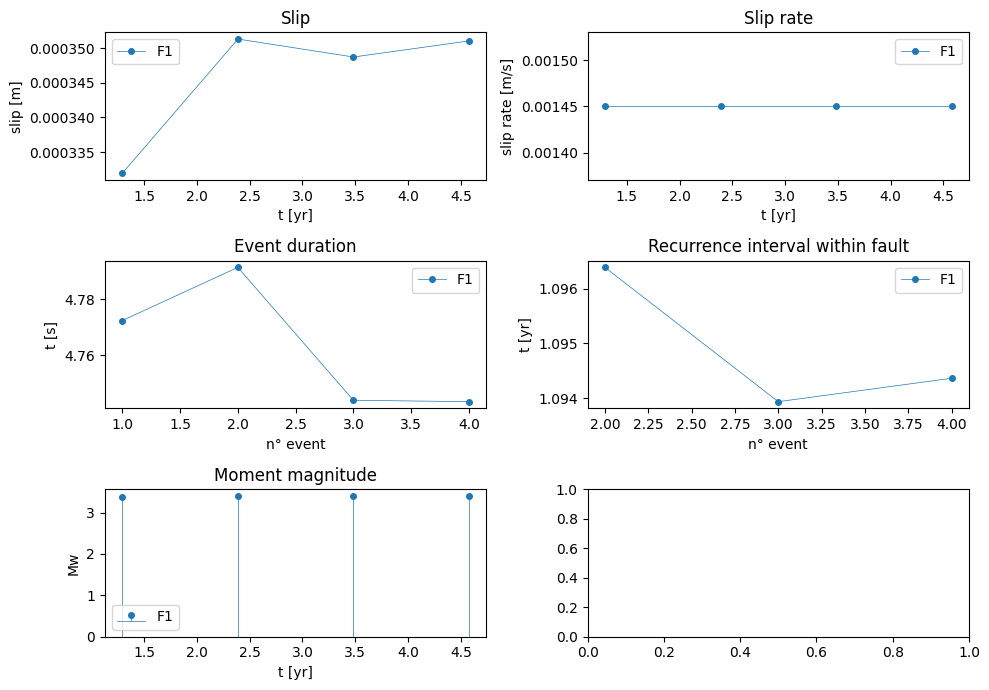

In [44]:
# plot event information
plt.close("all")

# Set the rc parameters for marker size and linewidth
plt.rc('lines', markersize=4, linewidth=0.5)

# create canvas
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), squeeze=False)

# Append suffix / prefix to strings in list label models

# Labels
lbl1 = "F1"

# Relevant Dataframes
df_ev1 = model_dict["ev"][1] # DataFrame with events of Fault 1
df_seq = model_dict["seq"]["1_2"] # DataFrame with interevent time between faults


## Plot quantities
#Slip
ax[0,0].plot(df_ev1["t_event"]/t_yr, df_ev1["cum_slip"], label = lbl1, marker="o")
ax[0,0].set_xlabel("t [yr]")
ax[0,0].set_ylabel("slip [m]")
ax[0,0].legend()
ax[0,0].set_title("Slip")

# Peak slip rate
ax[0,1].plot(df_ev1["t_event"]/t_yr, df_ev1["peak_v"], label = lbl1, marker="o")
ax[0,1].set_xlabel("t [yr]")
ax[0,1].set_ylabel("slip rate [m/s]")
ax[0,1].legend()
ax[0,1].set_title("Slip rate")

# Event duration
ax[1,0].plot(df_ev1.index, df_ev1["dt_event"], label = lbl1, marker="o")
ax[1,0].set_xlabel("n° event")
ax[1,0].set_ylabel("t [s]")
ax[1,0].legend()
ax[1,0].set_title("Event duration")

# Recurrence interval within fault
ax[1,1].plot(df_ev1.index, df_ev1["t_interevent_intrafault"]/t_yr, label = lbl1, marker="o")
ax[1,1].set_xlabel("n° event")
ax[1,1].set_ylabel("t [yr]")
ax[1,1].legend()
ax[1,1].set_title("Recurrence interval within fault")

# Moment magnitude
markerline1, stemlines1, baseline1 = ax[2,0].stem(df_ev1["t_event"]/t_yr,df_ev1["Mw"], linefmt="#1f77b4",label = "F1", markerfmt='o', basefmt= 'C0')
plt.setp(stemlines1, 'color', plt.getp(markerline1,'color'))
ax[2,0].set_ylim(bottom=0)
ax[2,0].set_xlabel("t [yr]")
ax[2,0].set_ylabel("Mw")
ax[2,0].legend()
ax[2,0].set_title("Moment magnitude")



fig.tight_layout()       
plt.show()

Next we can extract the location of nucleation points and its spatial frequency

In [45]:
# import function to extract events
from nucleation_point import nucleation_point

# Add to model_dict the information about nucleation points
model_dict_np = nucleation_point(p.mesh_dict, model_dict)

The information of the location point is stored in `model_dict_np["np"][<fault_label>]`. This includes: index (n event), step (timestep of nucleation), potcy_fault (potency of fault), pot_rate_fault (potency rate of the fault), vmax_fault (peak velocity at that timestep), ivmax_fault (index of element with peak velocity at nucleation), cum_slip_fault (cumulative slip of the fault from start of simualtion), fault_label, deltat (time duration of event), n_event, and coordinates x y z of nucleation point. 

The information of the location point frequency is stored in `model_dict_np["count_np"][<fault_label>]`. This includes: coordinates x y z, fault_label and count_np (absolute frequency)

In [46]:
# print information of location point for Fault 1
model_dict_np["np"][1]

,step,t,potcy_fault,pot_rate_fault,vmax_fault,ivmax_fault,deltat,n_event,cum_slip_fault,x,y,z,Mw,fault_label
n_event,,,,,,,,,,,,,,
1,1240,40770584.21932,1013433.0,701.1071,0.001012,8264,NaN,1,0.069272,2792.96875,2181.978068,-8740.234375,3.382267,1.0
2,2930,75346314.747607,1876654.0,824.6254,0.001091,8520,34575725.755845,2,0.128277,2792.96875,2249.636303,-8701.171875,3.398723,1.0
3,4620,109844612.71557,2738934.0,783.5217,0.001053,8520,34498293.176511,3,0.187217,2792.96875,2249.636303,-8701.171875,3.396574,1.0
4,6320,144356417.70051,3601899.0,827.7011,0.001098,8520,34511800.24097,4,0.246204,2792.96875,2249.636303,-8701.171875,3.398498,1.0


In [47]:
# print information of location point frequency for Fault 1
model_dict_np["count_np"][1]

,x,y,z,fault_label,count_np
0,19.53125,16.914559,-9990.234375,1.0,NaN
1,58.59375,16.914559,-9990.234375,1.0,NaN
2,97.65625,16.914559,-9990.234375,1.0,NaN
3,136.71875,16.914559,-9990.234375,1.0,NaN
4,175.78125,16.914559,-9990.234375,1.0,NaN
...,...,...,...,...,...
16379,4824.21875,4313.212460,-7509.765625,1.0,NaN
16380,4863.28125,4313.212460,-7509.765625,1.0,NaN
16381,4902.34375,4313.212460,-7509.765625,1.0,NaN
16382,4941.40625,4313.212460,-7509.765625,1.0,NaN
